In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [2]:
nTrajs = 12850 # 50 more for thermalization (12800/64=200)
N_md_list = [100, 8]
N = 5
J=0.1
h=0.5
beta = 1
#pretty plots
def beauty_plot():
    plt.figure(figsize=(10,5))
    plt.minorticks_on()
    plt.rcParams["mathtext.fontset"]="cm"
    plt.rcParams['errorbar.capsize'] = 3
    plt.rcParams['mathtext.rm'] = 'serif'
    font={'family' : 'serif','size'   : 22}
    plt.rc("font",**font)
    plt.xticks(fontsize=22,fontname='DejaVu Serif')
    plt.yticks(fontsize=22,fontname='DejaVu Serif')
    plt.grid(color='black',linestyle=':')

def leap_frog(N_md, p_0, phi_0, J):
    epsilon = 1/N_md
    p, phi = p_0, phi_0
    #first leap-frog step
    phi = phi+epsilon/2*p
    for i in range(0,N_md-1):
        p=p-epsilon*(phi/(beta*J)-N*np.tanh(beta*h+phi))
        phi=phi+epsilon*p
    #last step of leap-frog
    p=p-epsilon*(phi/(beta*J)-N*np.tanh(beta*h+phi))
    phi=phi+epsilon/2*p
    return p, phi
#artificial hamiltonian
def art_hamiltonian(p, phi,J, N):
    return p**2/2+phi**2/(2*beta*J)-N*np.log(2*np.cosh(beta*h+phi))

def numerical(N_md):
    phi_list = [1] # arbitrary start value
    m_observe = []
    energy_observe = []
    for traj in range(nTrajs):
        p_0 = np.random.normal(0,1) #sample randomly from normal dist.
        phi_0 = phi_list[-1] # each consecutive start value is phi from iteration before
        hamiltonian_0 = art_hamiltonian(p_0, phi_0, J/N, N) # calculate start hamilton
        # Calculate p' and phi'
        p, phi = leap_frog(N_md,p_0,phi_0, J/N)
        hamiltonian = art_hamiltonian(p, phi, J/N, N) # calculate end hamilton
        if np.random.uniform(0,1)<=np.exp(-beta*(hamiltonian-hamiltonian_0)):
            phi_list.append(phi) #accept
        else:
            phi_list.append(phi_0) #reject this is less than 50% for N_md=50
    # Measurements
    m = []
    e=[]
    for phi in phi_list:
        m.append(np.tanh(beta*h+phi)) # take measuremente like described above
        #e.append(-1/N*(phi*phi/(2*beta*beta*J/N)+h*N*np.tanh(beta*h+phi)-1/(2*beta)))
    
    return m, phi_list

m = []
phi = []
for N_md in N_md_list:
    m.append(numerical(N_md)[0])
    phi.append(numerical(N_md)[1])

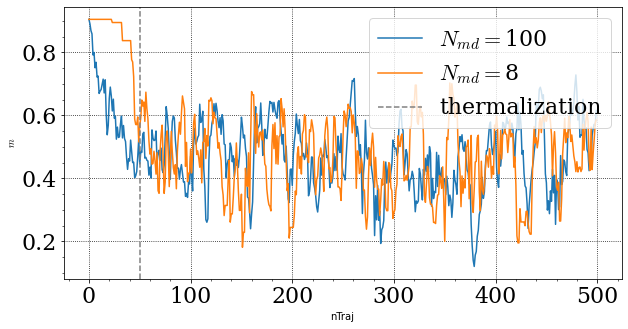

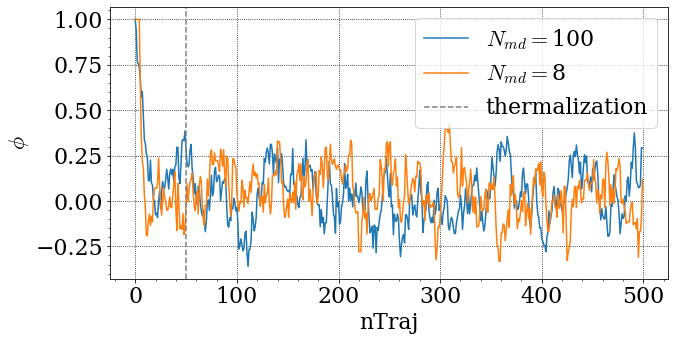

$\langle m \rangle = $0.48811479020728465

In [3]:
beauty_plot()
plt.plot(m[0][:500],label="$N_{md}=$%.d"%(N_md_list[0]))
plt.plot(m[1][:500],label="$N_{md}=$%.d"%(N_md_list[1]))
plt.axvline(x=50, color="gray", ls="--", label="thermalization")
plt.legend(loc='upper right')
plt.xlabel("nTraj")
plt.ylabel("$m$")
plt.show()

beauty_plot()
plt.plot(phi[0][:500],label="$N_{md}=$%.d"%(N_md_list[0]))
plt.plot(phi[1][:500],label="$N_{md}=$%.d"%(N_md_list[1]))
plt.axvline(x=50, color="gray", ls="--", label="thermalization")
plt.xlabel("nTraj")
plt.ylabel("$\\phi$")
plt.legend(loc='upper right')
plt.show()

m[0]=m[0][50:]
m[1]=m[1][50:]
printmd(f"$\\langle m \\rangle = ${np.mean(m[0])}")

In [4]:
m_mean = np.mean(m[0])

def gamma(t, m):
    m_sum = 0
    for i in range(len(m)-t):
        m_sum += (m[i]-m_mean)*(m[i+t]-m_mean)
    return 1/(len(m)-t)*m_sum

t_list = np.linspace(0,50,51,dtype="int")
y_0 = []
y_1 = []
gamma_0_m0 = gamma(0, m[0])
gamma_0_m1 = gamma(0, m[1])
for t in t_list:
    y_0.append(gamma(t, m[0])/gamma_0_m0)
    y_1.append(gamma(t, m[1])/gamma_0_m1)


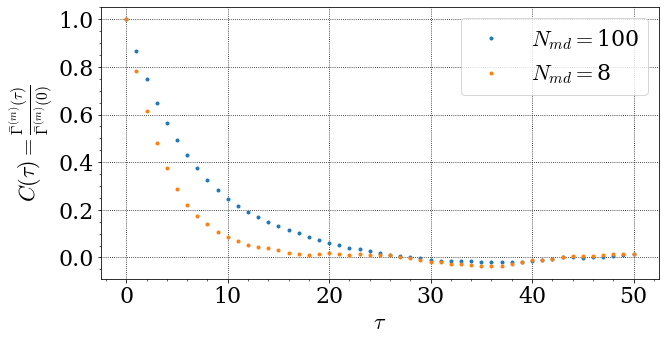

In [5]:
beauty_plot()
plt.plot(t_list,y_0,".", label="$N_{md}=$%.d"%(N_md_list[0]))
plt.plot(t_list,y_1,".",label="$N_{md}=$%.d"%(N_md_list[1]))
plt.xlabel("$\\tau$")
plt.ylabel("$C(\\tau)=\\frac{\\bar{\\Gamma}^{(m)}(\\tau)}{\\bar{\\Gamma}^{(m)}(0)}$")
plt.legend()
plt.show()

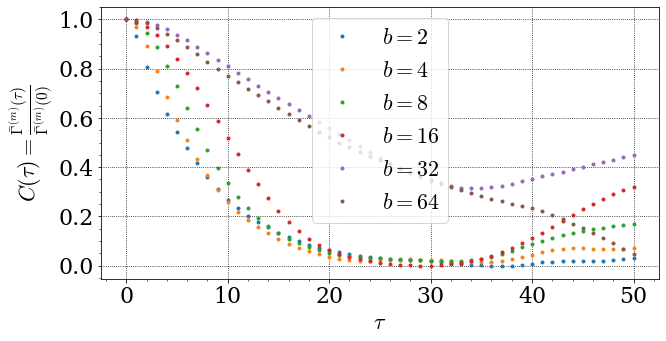

In [8]:
def block_generator(b, m):
    blocked_data = []
    for i in range(0,int((nTrajs-50)/b)):
        blocked_data.append(np.mean(m[i:i+b]))
    return blocked_data
            
b_list = [2,4,8,16,32,64]
blocked_list = []
for b in b_list:
    blocked_list.append(block_generator(b, m[0]))

t_list = np.linspace(0,50,51,dtype="int")
y_list = []
beauty_plot()
for i in range(0, len(b_list)):
    y_list.append([])
    gamma_0 = gamma(0, blocked_list[i])
    for t in t_list:
        y_list[i].append(gamma(t, blocked_list[i])/gamma_0)
    plt.plot(t_list,y_list[i],".", label="$b=%.d$"%(b_list[i]))
plt.xlabel("$\\tau$")
plt.ylabel("$C(\\tau)=\\frac{\\bar{\\Gamma}^{(m)}(\\tau)}{\\bar{\\Gamma}^{(m)}(0)}$")
plt.legend()
plt.show()

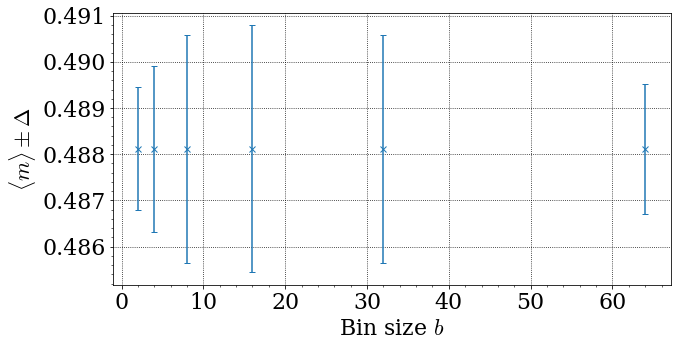

In [7]:
std = []
for i in range(0, len(b_list)):
    std.append(np.std(blocked_list[i])/np.sqrt((nTrajs-50)/b_list[i]))
beauty_plot()
plt.errorbar(b_list,[m_mean for i in range(len(b_list))],yerr=std, ls="None", marker="x")
plt.ylabel("$\\langle m \\rangle \pm \\Delta$")
plt.xlabel("Bin size $b$")
plt.show()